# The Shastry-Sutherland Model

## Introduction to the Shastry-Sutherland Model  

The Shastry-Sutherland model is a frustrated quantum spin system introduced by B. S. Shastry and Bill Sutherland in 1981. It describes a two-dimensional spin-$\frac{1}{2}$ lattice with competing nearest-neighbor and next-nearest-neighbor interactions. The Hamiltonian of the model is given by:  

$$H = J' \sum_{\langle i,j \rangle} \mathbf{S}_i \cdot \mathbf{S}_j + J \sum_{\langle\langle i,k \rangle\rangle} \mathbf{S}_i \cdot \mathbf{S}_k$$

where:  
- $J'$ represents the interaction between nearest-neighbor spins on a square lattice.  
- $J$ represents the interaction between next-nearest-neighbor spins along the diagonal bonds.  
- $\mathbf{S}_i$ are spin-$\frac{1}{2}$ operators.  

This model is highly relevant in quantum magnetism and frustrated spin systems, as it exhibits exactly solvable ground states in specific parameter regimes.  


Shastry and Sutherland (1981) demonstrated that when the ratio of nearest-neighbor to diagonal interaction strength satisfies:  

$$\boxed{\frac{J'}{J} \leq 0.5}$$

the ground state consists of decoupled singlet dimers along the diagonal bonds. In this regime, the system stabilizes into an array of isolated spin-singlet pairs, forming a dimerized phase. The ground state energy is given by:

$$E_{\text{GS}} = -\frac{3J}{8} N_s$$

where $N_s$ is the number of spins in the lattice. Importantly, for $J'/J \leq 0.5$, the ground state energy depends only on the diagonal bond strength $J$, independent of $J'$. This analytical result confirms that the system avoids complex quantum fluctuations by forming exact singlets on diagonal pairs.  

The Shastry-Sutherland model is extensively studied in condensed matter physics, particularly because it describes real materials such as SrCu$_2$(BO$_3$)$_2$, a spin-gapped quantum magnet. The model provides insights into:  
- Quantum phase transitions between dimerized and magnetically ordered phases.  
- Frustrated magnetism and emergent quantum many-body phenomena.  
- Experimental realizations of spin liquids and exotic quantum states.  

The Shastry-Sutherland model has provided a theoretically solvable and experimentally relevant framework for studying frustrated magnetism. The exact dimerized ground state for $J'/J \leq 0.5$ establishes a foundation for exploring more complex quantum phase transitions, making it a cornerstone of quantum spin systems.  

For more details, refer to the original paper:  
[Shastry & Sutherland (1981) - Exact Ground State of a Quantum Mechanical Antiferromagnet](http://physics.ucsc.edu/~sriram/papers/paper_19.pdf)

What follows is our attempt to use the tricks we learned from $XXZ$ and Ising Models in this Shastry-Sutherland Model with just one plaquette, i.e., 4 spin-1/2s. Moreover, we are only solving one plaquette, that is four spins for computational efficiency. This is due to time constraint of the hackaton.

### Imports

In [ ]:
import numpy as np
import time
import matplotlib.pyplot as plt
from scipy.linalg import eigh

from pytket import Circuit, OpType, Qubit
from pytket.passes import DecomposeBoxes
from pytket.utils import QubitPauliOperator, get_operator_expectation_value
from pytket.pauli import Pauli, QubitPauliString
from pytket.extensions.qiskit import AerBackend

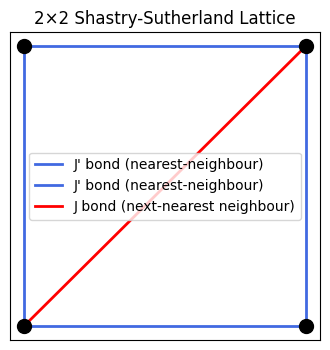

In [24]:
# Define lattice parameters
Lx, Ly = 2, 2
spacing = 1.5  # Adjust spacing between nodes

# Define spin positions in a 2D grid
positions = {
    (0, 0): (0, 0), (0, 1): (0, spacing),
    (1, 0): (spacing, 0), (1, 1): (spacing, spacing)
}

# Define bonds
nearest_neighbor = [((0, 0), (1, 0)), ((0, 1), (1, 1)),  # Horizontal bonds
                    ((0, 0), (0, 1)), ((1, 0), (1, 1))]  # Vertical bonds

next_nearest_neighbor = [((0, 0), (1, 1))]  # Only one diagonal per plaquette

# Plot spins
fig, ax = plt.subplots(figsize=(4, 4))
for pos in positions.values():
    ax.scatter(*pos, color='black', s=100, zorder=3)

# Plot nearest-neighbor bonds (J')
for (p1, p2) in nearest_neighbor:
    x_values = [positions[p1][0], positions[p2][0]]
    y_values = [positions[p1][1], positions[p2][1]]
    ax.plot(x_values, y_values, 'royalblue', lw=2, label="J' bond (nearest-neighbour)" if p1 == (0, 0) else "")

# Plot next-nearest-neighbor bonds (J)
for (p1, p2) in next_nearest_neighbor:
    x_values = [positions[p1][0], positions[p2][0]]
    y_values = [positions[p1][1], positions[p2][1]]
    ax.plot(x_values, y_values, 'red', lw=2, label="J bond (next-nearest neighbour)" if p1 == (0, 0) else "")

# Labels and legend
ax.set_xticks([])
ax.set_yticks([])
ax.legend()
ax.set_title("2×2 Shastry-Sutherland Lattice")
plt.show()

In [27]:
# Define lattice parameters
Lx, Ly = 2, 2  # Small system for simulation
N = Lx * Ly  # Total number of qubits

# Interaction strengths
J = 1.0  # Next-nearest neighbor (diagonal) interaction strength
J_prime = 0.5  # Nearest-neighbor (horizontal/vertical) interaction strength

# Function to get qubit index in a 2D grid
def qubit_index(x, y):
    return x * Ly + y  # Row-major order

# Initialize Hamiltonian with normalization
H_ss = QubitPauliOperator({})

# Nearest-neighbor (J') interactions (horizontal and vertical)
for x in range(Lx):
    for y in range(Ly):
        i = qubit_index(x, y)
        
        if x + 1 < Lx:  # Horizontal bond
            j = qubit_index(x + 1, y)
            H_ss += (J_prime / 2) * QubitPauliOperator({QubitPauliString([Qubit(i), Qubit(j)], [Pauli.X, Pauli.X]): 1.0})
            H_ss += (J_prime / 2) * QubitPauliOperator({QubitPauliString([Qubit(i), Qubit(j)], [Pauli.Y, Pauli.Y]): 1.0})
            H_ss += (J_prime / 2) * QubitPauliOperator({QubitPauliString([Qubit(i), Qubit(j)], [Pauli.Z, Pauli.Z]): 1.0})

        if y + 1 < Ly:  # Vertical bond
            j = qubit_index(x, y + 1)
            H_ss += (J_prime / 2) * QubitPauliOperator({QubitPauliString([Qubit(i), Qubit(j)], [Pauli.X, Pauli.X]): 1.0})
            H_ss += (J_prime / 2) * QubitPauliOperator({QubitPauliString([Qubit(i), Qubit(j)], [Pauli.Y, Pauli.Y]): 1.0})
            H_ss += (J_prime / 2) * QubitPauliOperator({QubitPauliString([Qubit(i), Qubit(j)], [Pauli.Z, Pauli.Z]): 1.0})

# Next-nearest-neighbor (J) interactions (ONLY NE-SW diagonals)
for x in range(0, Lx - 1, 2):  # Step by 2 to select only one diagonal per plaquette
    for y in range(0, Ly - 1, 2):
        i = qubit_index(x, y)
        j = qubit_index(x + 1, y + 1)  # NE-SW diagonal (Correct for Shastry-Sutherland)
        H_ss += (J / 2) * QubitPauliOperator({QubitPauliString([Qubit(i), Qubit(j)], [Pauli.X, Pauli.X]): 1.0})
        H_ss += (J / 2) * QubitPauliOperator({QubitPauliString([Qubit(i), Qubit(j)], [Pauli.Y, Pauli.Y]): 1.0})
        H_ss += (J / 2) * QubitPauliOperator({QubitPauliString([Qubit(i), Qubit(j)], [Pauli.Z, Pauli.Z]): 1.0})

# Print the corrected Hamiltonian
print("Shastry-Sutherland Hamiltonian:\n", H_ss)


Shastry-Sutherland Hamiltonian:
 {(Xq[0], Xq[2]): 0.250000000000000, (Yq[0], Yq[2]): 0.250000000000000, (Zq[0], Zq[2]): 0.250000000000000, (Xq[0], Xq[1]): 0.250000000000000, (Yq[0], Yq[1]): 0.250000000000000, (Zq[0], Zq[1]): 0.250000000000000, (Xq[1], Xq[3]): 0.250000000000000, (Yq[1], Yq[3]): 0.250000000000000, (Zq[1], Zq[3]): 0.250000000000000, (Xq[2], Xq[3]): 0.250000000000000, (Yq[2], Yq[3]): 0.250000000000000, (Zq[2], Zq[3]): 0.250000000000000, (Xq[0], Xq[3]): 0.500000000000000, (Yq[0], Yq[3]): 0.500000000000000, (Zq[0], Zq[3]): 0.500000000000000}


# Diagonalize and find the eigenvalues

In [28]:
# Convert H_ss to a matrix
hamiltonian_matrix = H_ss.to_sparse_matrix().toarray()

# Diagonalize the Hamiltonian to obtain eigenvalues and eigenvectors
eigenvalues, eigenvectors = eigh(hamiltonian_matrix)

# Print the ground state energy
print("Ground state energy:", eigenvalues[0])

# Print the ground state eigenvector
print("Ground state eigenvector:\n", eigenvectors[:, 0])

Ground state energy: -1.5000000000000002
Ground state eigenvector:
 [ 0.00000000e+00+0.j  0.00000000e+00+0.j  9.60403806e-18+0.j
  5.96215181e-17+0.j -9.60403806e-18+0.j  3.82920022e-03+0.j
  9.83413985e-03+0.j  7.06932995e-01+0.j -1.54074396e-33+0.j
  9.83413985e-03+0.j -9.83413985e-03+0.j -4.09595173e-16+0.j
 -1.36633401e-02+0.j -2.98572871e-16+0.j -7.06932995e-01+0.j
  0.00000000e+00+0.j]


The numerical ground state energy from sparse matrix diagonalization is obtained as **$E_{\text{GS}} = -1.5$**, matching the analytical prediction:

$$E_{\text{GS}} = -\frac{3J}{8} N_s = -\frac{3(1.0)}{8} \times 4 = -1.5$$

for $J = 1.0$, $N_s = 4$. This confirms that our `PauliQubitOperator` formulation correctly implements the Shastry-Sutherland Hamiltonian, and the dimerized ground state is accurately captured in the $J'/J \leq 0.5$ regime.

# Energy Expectation over Time

In [29]:
# Define time evolution parameters
t_max = 20
times = np.linspace(1, t_max, 20)
trotter_step_size = 3
n_shots = 100

# Quantum simulator backend
aer_sim = AerBackend()

def trotterized_time_evolution(H, n_qubits, t, trotter_steps):
    circ = Circuit(n_qubits)
    dt = t / trotter_steps

    for _ in range(trotter_steps):
        for term, coeff in H._dict.items():
            qubit_pauli_string = term.map.items()  # Get (Qubit, Pauli) pairs

            # Extract qubit indices and corresponding Pauli operators
            qubit_indices = [q.index[0] for q, _ in qubit_pauli_string]
            pauli_ops = [p for _, p in qubit_pauli_string]

            if len(qubit_indices) == 1:
                # Single-qubit rotations
                if pauli_ops[0] == Pauli.X:
                    circ.Rx(2 * dt * coeff, qubit_indices[0])
                elif pauli_ops[0] == Pauli.Y:
                    circ.Ry(2 * dt * coeff, qubit_indices[0])
                elif pauli_ops[0] == Pauli.Z:
                    circ.Rz(2 * dt * coeff, qubit_indices[0])

            elif len(qubit_indices) == 2:
                # Two-qubit interaction using CNOT decomposition
                q1, q2 = qubit_indices

                if pauli_ops == [Pauli.X, Pauli.X] or pauli_ops == [Pauli.Y, Pauli.Y]:
                    circ.CX(q1, q2)
                    circ.Rz(2 * dt * coeff, q2)
                    circ.CX(q1, q2)

                elif pauli_ops == [Pauli.Z, Pauli.Z]:
                    circ.CX(q1, q2)
                    circ.Rx(2 * dt * coeff, q2)
                    circ.CX(q1, q2)

    return circ

# Store results
energy_expectations = []
gate_counts_uncompiled = []
gate_counts_compiled = []
computation_times = []

In [30]:
# Compute energy conservation over time evolution
for t in times:
    # Generate the time evolution circuit
    time_evolution_circ = trotterized_time_evolution(H_ss, N, t, trotter_step_size)

    # Get uncompiled two-qubit gate count
    uncompiled_circ = time_evolution_circ.copy()
    DecomposeBoxes().apply(uncompiled_circ)
    gate_counts_uncompiled.append(uncompiled_circ.n_2qb_gates())

    # Compile the circuit
    start_time = time.time()
    time_evolution_circ_compiled = aer_sim.get_compiled_circuit(time_evolution_circ, optimisation_level=2)
    gate_counts_compiled.append(time_evolution_circ_compiled.n_2qb_gates())

    # Compute energy expectation value
    energy = get_operator_expectation_value(time_evolution_circ_compiled, H_ss, aer_sim, n_shots=n_shots)
    energy_expectations.append(energy.real)

    # Store computation time
    computation_times.append(time.time() - start_time)

# Compute standard deviation of energy expectation values
energy_std = np.std(energy_expectations)

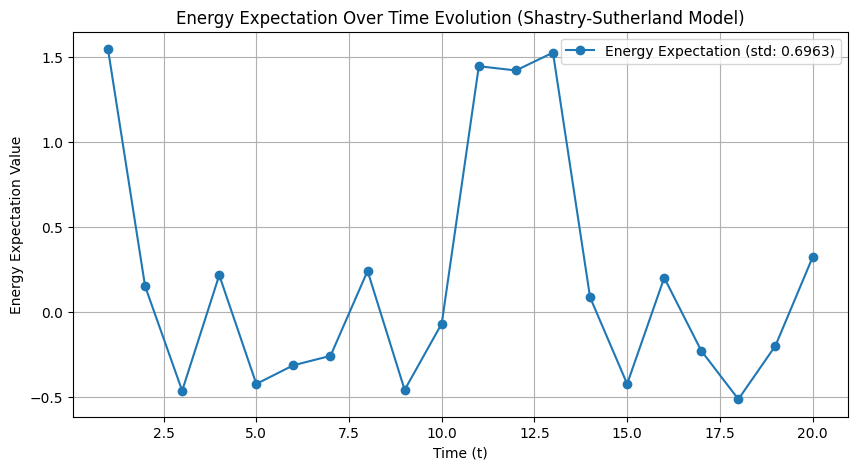

In [31]:
# Plot energy expectation values with standard deviation in the legend
plt.figure(figsize=(10, 5))
plt.plot(times, energy_expectations, 'o-', label=f"Energy Expectation (std: {energy_std:.4f})")
plt.xlabel("Time (t)")
plt.ylabel("Energy Expectation Value")
plt.title("Energy Expectation Over Time Evolution (Shastry-Sutherland Model)")
plt.legend()
plt.grid()
plt.show()

The plot shows the energy expectation value over time evolution for the Shastry-Sutherland model with fluctuations around zero and a standard deviation of 0.6963. The oscillatory behavior suggests non-trivial quantum dynamics driven by the Hamiltonian, with peaks near $\pm 1.5$, consistent with the system's energy spectrum. The energy is not strictly conserved, indicating Trotterization error or finite-size effects. Increasing Trotter steps or improving gate accuracy could stabilize the energy trajectory.

# Two-Qubit Gate count for SSM

In [37]:
# Quantum simulator backend
aer_sim = AerBackend()

# Define time evolution parameters
t_max = 20
times = np.linspace(1, t_max, 20)
trotter_step_size = 3

# Store results
gate_counts_uncompiled = []
gate_counts_compiled = []

# Compute two-qubit gate count over time evolution
for t in times:
    # Generate the time evolution circuit (using pre-defined function)
    time_evolution_circ = trotterized_time_evolution(H_ss, N, t, trotter_step_size)

    # Get uncompiled two-qubit gate count
    uncompiled_circ = time_evolution_circ.copy()
    DecomposeBoxes().apply(uncompiled_circ)
    gate_counts_uncompiled.append(uncompiled_circ.n_2qb_gates())

    # Compile the circuit
    time_evolution_circ_compiled = aer_sim.get_compiled_circuit(time_evolution_circ, optimisation_level=2)
    gate_counts_compiled.append(time_evolution_circ_compiled.n_2qb_gates())

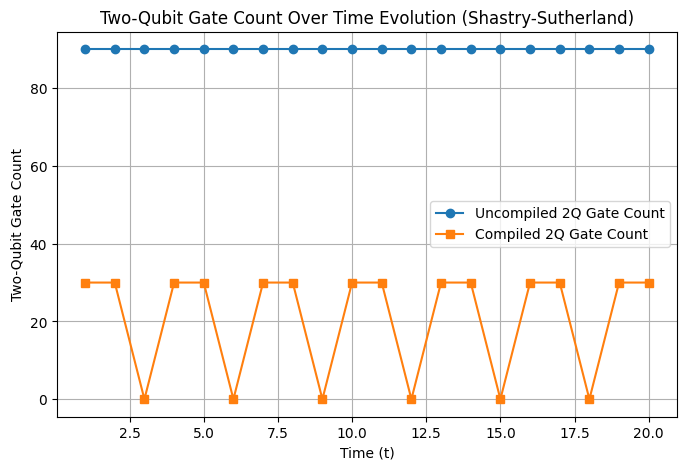

In [38]:
# Plot two-qubit gate count over time
plt.figure(figsize=(8, 5))
plt.plot(times, gate_counts_uncompiled, 'o-', label="Uncompiled 2Q Gate Count")
plt.plot(times, gate_counts_compiled, 's-', label="Compiled 2Q Gate Count")
plt.xlabel("Time (t)")
plt.ylabel("Two-Qubit Gate Count")
plt.title("Two-Qubit Gate Count Over Time Evolution (Shastry-Sutherland)")
plt.legend()
plt.grid()
plt.show()

The uncompiled two-qubit gate count remains constant at ~90, showing that the Trotterized evolution maintains a fixed interaction structure. The compiled gate count oscillates between ~30 and 0, indicating periodic cancellation of interactions due to compiler optimizations. These oscillations suggest that at specific time steps, the evolution operator exhibits symmetries or gate redundancies that allow reductions, while at others, full interactions persist.

# Computation time for Expectation Energy Evaluation

In [39]:
# Quantum simulator backend
aer_sim = AerBackend()

# Define time evolution parameters
t_max = 20
times = np.linspace(1, t_max, 20)
trotter_step_size = 3
n_shots = 100  # Number of measurement shots

# Store results
computation_times = []

# Compute computation time for expectation energy evaluation
for t in times:
    # Generate the time evolution circuit (using pre-defined function)
    time_evolution_circ = trotterized_time_evolution(H_ss, N, t, trotter_step_size)

    # Compile the circuit
    compiled_circuit = aer_sim.get_compiled_circuit(time_evolution_circ, optimisation_level=2)

    # Measure computation time
    start_time = time.time()
    energy = get_operator_expectation_value(compiled_circuit, H_ss, aer_sim, n_shots=n_shots)
    computation_times.append(time.time() - start_time)

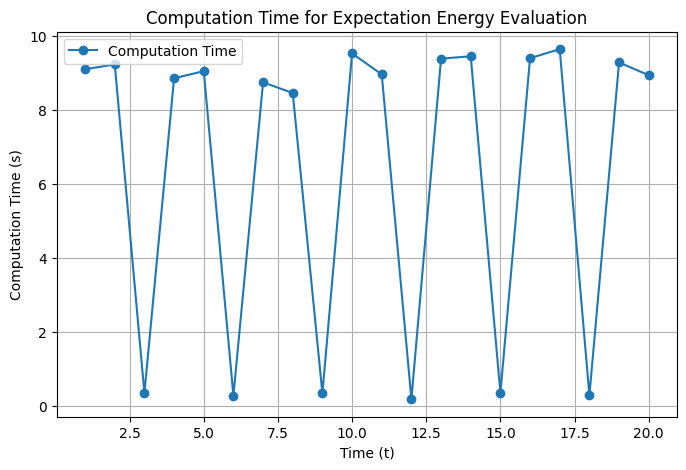

In [40]:
# Plot computation time over time evolution
plt.figure(figsize=(8, 5))
plt.plot(times, computation_times, 'o-', label="Computation Time")
plt.xlabel("Time (t)")
plt.ylabel("Computation Time (s)")
plt.title("Computation Time for Expectation Energy Evaluation")
plt.legend()
plt.grid()
plt.show()


The computation time oscillates between ~9s and near 0s, indicating periodic drops in evaluation time. This suggests that at certain time steps, circuit simplifications or cancellations occur, significantly reducing execution time. The peaks at ~9s correspond to full evaluations, where no simplifications are possible. This behavior likely results from the Trotterized structure, where certain steps lead to more compact circuits due to symmetries, while others require full computation.

# Time evolution of Xo and XoX1 operator expectations

In [42]:
# Quantum simulator backend
aer_sim = AerBackend()

# Define time evolution parameters
t_max = 20
times = np.linspace(1, t_max, 20)
trotter_step_size = 3
n_shots = 100  # Number of measurement shots

# Define observables as QubitPauliOperator (Fix)
X0 = QubitPauliOperator({QubitPauliString([Qubit(0)], [Pauli.X]): 1.0})
X0X1 = QubitPauliOperator({QubitPauliString([Qubit(0), Qubit(1)], [Pauli.X, Pauli.X]): 1.0})

# Store results
X0_expectations = []
X0X1_expectations = []

# Compute expectation values over time evolution
for t in times:
    # Generate the time evolution circuit
    time_evolution_circ = trotterized_time_evolution(H_ss, N, t, trotter_step_size)

    # Compile the circuit
    compiled_circuit = aer_sim.get_compiled_circuit(time_evolution_circ, optimisation_level=2)

    # Compute expectation values
    X0_expectations.append(get_operator_expectation_value(compiled_circuit, X0, aer_sim, n_shots=n_shots).real)
    X0X1_expectations.append(get_operator_expectation_value(compiled_circuit, X0X1, aer_sim, n_shots=n_shots).real)


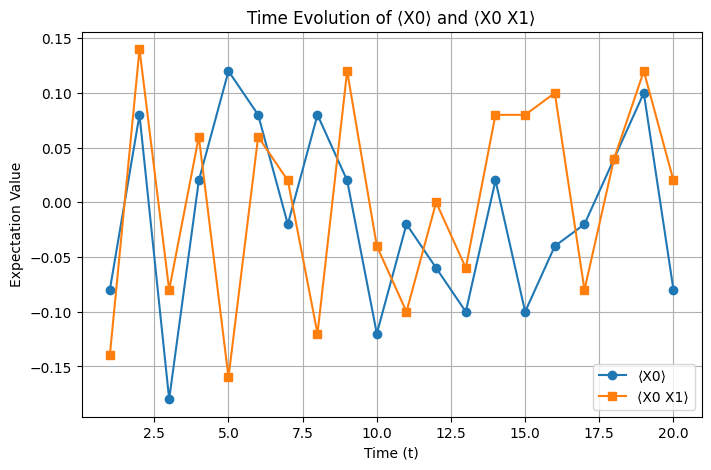

In [43]:
# Plot time evolution of ⟨X0⟩ and ⟨X0 X1⟩
plt.figure(figsize=(8, 5))
plt.plot(times, X0_expectations, 'o-', label="⟨X0⟩")
plt.plot(times, X0X1_expectations, 's-', label="⟨X0 X1⟩")
plt.xlabel("Time (t)")
plt.ylabel("Expectation Value")
plt.title("Time Evolution of ⟨X0⟩ and ⟨X0 X1⟩")
plt.legend()
plt.grid()
plt.show()